In [0]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [0]:
BATCH_SIZE = 100
## transformations
transform = transforms.Compose([transforms.ToTensor()])
## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

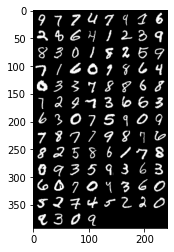

In [4]:
import matplotlib.pyplot as plt
import numpy as np
## functions to show an image
def imshow(img):
    # print(img.transpose(0, 1).transpose(1, 2).size())
    # print(img.permute(1, 2, 0).size())
    # print(img.size())
    npimg = img.numpy()
    plt.imshow(npimg.transpose(1, 2, 0))
## get some random training images
images, labels = next(iter(trainloader))
## show images
imshow(torchvision.utils.make_grid(images))

In [0]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5) # 28x28x1 => 24x24x24
        self.d1 = nn.Linear(24 * 24 * 24, 112)
        self.d2 = nn.Linear(112, 10)
    def forward(self, x):
        x = self.conv1(x) # 32x1x28x28 => 32x24x24x24
        x = F.relu(x)
        x = x.flatten(start_dim = 1) # flatten => 32 x (24x24x24)
        x = self.d1(x) # 32 x (24x24x24) => 32x128
        x = F.relu(x)
        x = self.d2(x) # logits => 32x10
        x = F.softmax(x, dim=1)
        return x

In [0]:
## compute accuracy
def get_accuracy(y, target):
    corrects = (torch.max(y, 1).indices == target).sum()
    accuracy = 100.0 * corrects / target.shape[0]
    return accuracy.item()

In [21]:
ETA = 0.001
EPOCHS = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('using', device)
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=ETA)

using cuda:0


In [22]:
for epoch in range(EPOCHS):
    train_loss = 0.0
    train_accu = 0.0
    ## training step
    model.train()
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        ## forward pass
        y = model(images)
        ## calculate loss
        loss = criterion(y, labels)
        ## accumalate gradient
        loss.backward()
        ## update model params
        optimizer.step()
        ## zero-out accumalated gradients
        optimizer.zero_grad()
        with torch.no_grad():
            train_loss += loss.item() / len(trainset) * BATCH_SIZE
            train_accu += get_accuracy(y, labels) / len(trainset) * BATCH_SIZE
    test_accu = 0.0
    ## evaluating step
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            test_accu += get_accuracy(outputs, labels) / len(testset) * BATCH_SIZE
    print(f'Epoch: {epoch} | Loss: {train_loss:.6f} | Train Accuracy: {train_accu:.2f} | Test Accuracy: {test_accu:.2f}') 

Epoch: 0 | Loss: 1.619522 | Train Accuracy: 84.69 | Test Accuracy: 87.79
Epoch: 1 | Loss: 1.578523 | Train Accuracy: 88.22 | Test Accuracy: 88.46
Epoch: 2 | Loss: 1.519715 | Train Accuracy: 94.25 | Test Accuracy: 97.83
Epoch: 3 | Loss: 1.478247 | Train Accuracy: 98.42 | Test Accuracy: 98.09
Epoch: 4 | Loss: 1.474604 | Train Accuracy: 98.77 | Test Accuracy: 98.53
